# **Quantium Chips Customer Analysis** <br>
**Elijah Olusunmade**<br>
**Initially Created:** 19/10/2023<br>
**Last update:** 31/10/2023<br>
<!-- <img src = './Pictures/chips.jpg' width=800> -->

## **Project Goals**

1. **Clean**, **Manipulate** and **Prepare** data for exploratory analysis.
1. **Explore** customer transaction data and identify insights to *`chips purchase behavior`*.
2. **Identify** *`customer segments`* that contribute the most to sales.
3. **Investigate** which *`brand`* and *`size`* customers have the most *`affinity`* to and *`association`* between brands.

## **About this dataset**
This data is provided courtesy of [Quantium](https://quantium.com/) via [Forage Virtual Experience Program](https://www.theforage.com/virtual-experience/NkaC7knWtjSbi6aYv/quantium/data-analytics/data-preparation-and-customer-analytics).<br>
Two datasets were provided, a transaction dataset and a dimension dataset for the customers.

## **List Of Contents**

0. [Preface: Importing Needed Modules](#importing_modules)<br>
1. [Data Loading and Cleaning](#data_loading)<br>
    1.1. [Load And Inspect Data](#load_inspect)<br>
    1.2. [Clean Date Column](#clean_date)<br>
    1.3. [Removing Salsa Products](#remove_salsa_prod)<br>
    1.4. [Extract Product Size and Brand Name](#ext_prodsize_brandname)<br>
    1.5. [Check and Remove Outliers](#remove_outliers)<br>
2. [Exploratory Data Analysis Of Chips Transaction](#eda_transactions)<br>
    2.1. [Analysis By Product's Brand Name](#analyse_brand)<br>
    2.2. [Analysis By Date](#analyse_date)<br>
    2.3. [Analysis By Product Size](#analyse_prodsize)<br>
3. [Load, Merge And Analyse Both Datasets](#load_merge_datasets)<br>
    3.1. [Load Customer Data](#load_cust_data)<br>
    3.2. [Merge Transaction and Customer Data](#merge_datasets)<br>
    3.3. [Analysing Number Of Customers Per Category](#num_customer_pergroup)<br>
    3.4. [No. Of Transactions Per Customers' Category](#transacts_per_group)<br>
    3.5. [Sales And Quantity Purchased By Customer Category](#sales_by_category)<br>
    
4. [Independent Ttest, Basket Analysis/Affinity Test](#statistical_analysis)<br>
    4.1. [Overview Of Independent T-test](#ttest_overview)<br>
    4.2. [Independent T-test Analysis](#ttest_analysis)<br>
    4.3. [Overview Of Market Basket Analysis](#mba_overview)<br>
    4.4. [MBA By Brand For "Mainstream young people](#mainyoung_brand_affinity)<br>
    4.5. [MBA By "Prod_SIze" For "Mainstream young people"](#mainyoung_size_affinity)<br>
    4.6. [MBA By "Prod_SIze" For Remaining Customers](#rem_cust_size_affinity)<br>

<a id='importing_modules'></a>
## <ins> 0. **Preface: Importing Needed Modules** </ins>

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import datetime as dt
import re

from scipy.stats import ttest_ind
from nltk.util import ngrams
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
# Declaring The Fonts For Plot Title And Axis Label Before Progressing. 
labelFont = {"family": "serif",
             "color": "black",
             "weight": "bold",
             "size": 12    
}
title_font = {"family": "serif",
             "color": "darkblue",
             "weight": "bold",
             "size": 14    
}
tick_size = 10


<a id='data_loading'></a>
## <ins> 1. **Data Loading and Cleaning** </ins>

<a id='load_inspect'></a>
### 1.1. Load And Inspect Data
The Transaction Dataset is loaded into Pandas here, checking the shape shows that the dataset has *`264836 rows and 8 columns`*, observed the top 5 rows of the data and checked for missing values .

In [3]:
allTrans = pd.read_excel(
    "C:/Users/DELL/Documents/Data_analytics_projects/Quantium/QVI_transaction_data.xlsx")

print(allTrans.shape)
allTrans.head()

(264836, 8)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [4]:
#CHECKING FOR MISSING VALUES IN THE DATASET.
allTrans.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

<a id='clean_date'></a>
### 1.2. Clean Date Column
The date column which is in dtype 'int64' format will be converted into a 'datetime' format and the dataframe will be sorted in ascending order by the date.

In [5]:
allTrans['DATE'] = pd.TimedeltaIndex(
    allTrans['DATE'], unit='d') + dt.datetime(1899, 12, 30)

In [6]:
allTrans.sort_values("DATE", inplace=True)
allTrans = allTrans.reset_index(drop=True)
allTrans.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-07-01,19,19205,16466,26,Pringles Sweet&Spcy BBQ 134g,1,3.7
1,2018-07-01,189,189381,190189,84,GrnWves Plus Btroot & Chilli Jam 180g,1,3.1
2,2018-07-01,124,124236,127984,104,Infuzions Thai SweetChili PotatoMix 110g,1,3.8
3,2018-07-01,70,70131,68241,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2
4,2018-07-01,33,33140,30342,10,RRD SR Slow Rst Pork Belly 150g,2,5.4


<a id='remove_salsa_prod'></a>
### 1.3. Removing Salsa Products
This is a chips focused analysis, so we have to remove *`Salsa`* products. Now we have *`246742 rows and 8 columns`*.

In [7]:
allTrans = allTrans[
    allTrans["PROD_NAME"].str.contains("Salsa")==False].reset_index(drop=True)
print(allTrans.shape)
allTrans.head()

(246742, 8)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-07-01,19,19205,16466,26,Pringles Sweet&Spcy BBQ 134g,1,3.7
1,2018-07-01,189,189381,190189,84,GrnWves Plus Btroot & Chilli Jam 180g,1,3.1
2,2018-07-01,124,124236,127984,104,Infuzions Thai SweetChili PotatoMix 110g,1,3.8
3,2018-07-01,70,70131,68241,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2
4,2018-07-01,33,33140,30342,10,RRD SR Slow Rst Pork Belly 150g,2,5.4


<a id='ext_prodsize_brandname'></a>
### 1.4. Extract Product Size and Brand Name
This section focuses on extracting the *`Product Size`* and *`Brand Name`* from *`'PROD_NAME'`* column.

In [8]:
# EXTRACTING THE "Product Size" FROM "PROD_NAME"
allTrans['PROD_SIZE(grams)'] = [
    re.search(r"[\d]+(g|G)", prod).group(0).replace('G',
                                            '').replace('g','') for prod in allTrans['PROD_NAME']]

In [9]:
# REMOVING EXCESS SPACES AND "&" IN "PROD_NAME"
allTrans['PROD_NAME'] = [" ".join(prod.replace('&',
                                    ' ').split()) for prod in allTrans['PROD_NAME']]

In [10]:
# REMOVING DIGITS FROM THE "PROD_NAME"
allTrans['PROD_NAME'] = [re.sub(r"(\s)*(\d)+(g|G)", 
                                r"", prod) for prod in allTrans['PROD_NAME']]

In [11]:
# EXTRACTING "Brand_Name" FROM THE "PROD_NAME"
allTrans['BRAND_NAME'] = [prod.split()[0] for prod in allTrans['PROD_NAME']]

In [12]:
# STANDARDISING THE BRAND NAME.
def editBrandName(string):
    string = re.sub(r"Red", "RRD", string)
    string = re.sub(r"Dorito", "Doritos", string)
    string = re.sub(r"Doritoss", "Doritos", string)
    string = re.sub(r"Smith", "Smiths", string)
    string = re.sub(r"Smithss", "Smiths", string)
    string = re.sub(r"GrnWves", "Grain Waves", string)
    string = re.sub(r"Woolworths", "WW", string) 
    string = re.sub(r"Snbts", "Sunbites", string) 

    return string

allTrans['BRAND_NAME'] = [editBrandName(brand) for brand in allTrans['BRAND_NAME']]

In [13]:
# REARRANGING THE COLUMN INDEX.
reindex_col = ['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'BRAND_NAME', 'PROD_SIZE(grams)', 'PROD_QTY', 'TOT_SALES']
allTrans = allTrans.reindex(columns=reindex_col)
allTrans.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND_NAME,PROD_SIZE(grams),PROD_QTY,TOT_SALES
0,2018-07-01,19,19205,16466,26,Pringles Sweet Spcy BBQ,Pringles,134,1,3.7
1,2018-07-01,189,189381,190189,84,GrnWves Plus Btroot Chilli Jam,Grain Waves,180,1,3.1
2,2018-07-01,124,124236,127984,104,Infuzions Thai SweetChili PotatoMix,Infuzions,110,1,3.8
3,2018-07-01,70,70131,68241,60,Kettle Tortilla ChpsFeta Garlic,Kettle,150,2,9.2
4,2018-07-01,33,33140,30342,10,RRD SR Slow Rst Pork Belly,RRD,150,2,5.4


<a id='remove_outliers'></a>
### 1.5. Check and Remove Outliers
This section focuses on checking for *`outliers`* in the dataset and removing them so it doesn't influence the analysis later on.<br>
The daaset summary and *`"PROD_QTY"`* value count shows that there are 2 transaction outliers where *`200`* prodcuts were bought at once. These purchase were made by one person, an wholesaler, these transactions will be removed from the dataset.

In [14]:
allTrans.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


In [15]:
print(allTrans['PROD_QTY'].value_counts())
filt200 = allTrans['PROD_QTY']==200
allTrans.loc[filt200]

PROD_QTY
2      220070
1       25476
5         415
3         408
4         371
200         2
Name: count, dtype: int64


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND_NAME,PROD_SIZE(grams),PROD_QTY,TOT_SALES
33284,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,Doritos,380,200,650.0
218895,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,Doritos,380,200,650.0


In [16]:
# allTrans.drop(index = allTrans[filt200].index, inplace = True)
# allTrans = allTrans.reset_index(drop=True)
allTrans = allTrans[allTrans['PROD_QTY'] < 200].reset_index(drop=True)

<a id='eda_transactions'></a>
## <ins> 2. **Exploratory Data Analysis Of Chips Transaction** </ins>

<a id='analyse_brand'></a>
### 2.1. Analysis By Product's Brand Name
Analysing by Product's Brand shows that *`Kettle brand`* sold the most quantity and recorded the highest number of transactions too for the duration of the analysis.

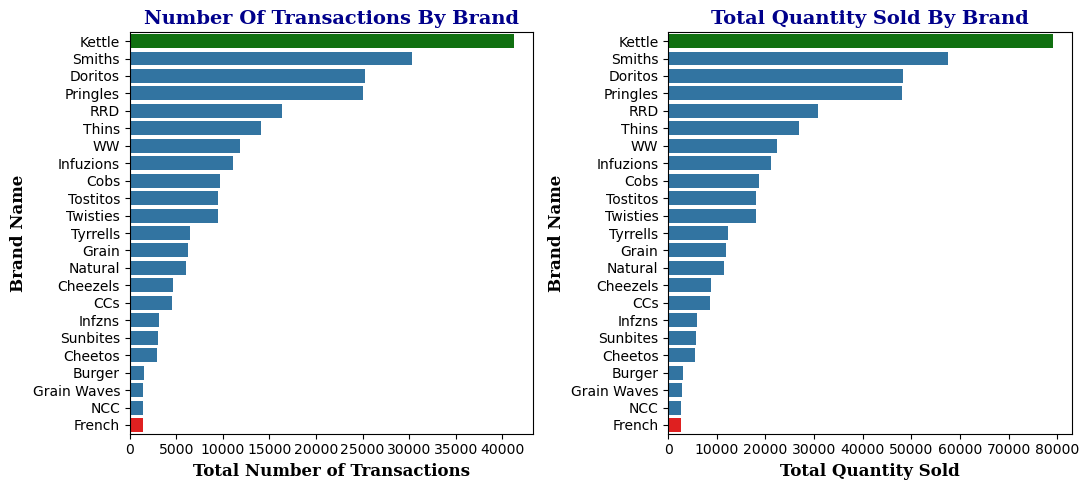

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

# PLOT 1: TOTAL No. OF TRANSACTIONS RECORDED FOR EACH BRAND
brandByTrCount = allTrans.groupby(
    ['BRAND_NAME'], as_index=False)['TXN_ID'].count().sort_values('TXN_ID', ascending=False)
ax1=plt.subplot(121)
plt.xticks(rotation=0, fontsize=tick_size)
plt.yticks(rotation=0, fontsize=tick_size)
plt.xlabel('Total Number of Transactions', fontdict=labelFont)
plt.ylabel('Brand Name', fontdict=labelFont)
plt.title('Number Of Transactions By Brand', fontdict=title_font)

# plt.subplot(1, 2, 1) #the figure has 1 row, 2 columns, and this plot is the first plot. 
# plt.subplot(1, 2, 2) # the figure has 1 row, 2 columns, and this plot is the second plot.
sns.barplot(x='TXN_ID', y="BRAND_NAME", data = brandByTrCount, ax = ax1)
sns.barplot(x='TXN_ID', y="BRAND_NAME", data = brandByTrCount[
    (brandByTrCount["BRAND_NAME"] == "Kettle")], color='green', ax = ax1)
sns.barplot(x='TXN_ID', y="BRAND_NAME", data = brandByTrCount[
    (brandByTrCount["BRAND_NAME"] == "French")], color='red', ax = ax1)
# # ax1.bar_label(ax1.containers[0], rotation=30, fontsize=10)


# PLOT 2: TOTAL QUANTITY SOLD BY EACH BRAND
brandByQty = allTrans.groupby(
    ['BRAND_NAME'], as_index=False).agg(
    {'PROD_QTY': 'sum'}).sort_values('PROD_QTY', ascending=False)
ax2=plt.subplot(122)
plt.xticks(rotation=0, fontsize=tick_size)
plt.yticks(rotation=0, fontsize=tick_size)
plt.xlabel('Total Quantity Sold', fontdict=labelFont)
plt.ylabel('Brand Name', fontdict=labelFont)
plt.title('Total Quantity Sold By Brand', fontdict=title_font)

sns.barplot(x='PROD_QTY', y="BRAND_NAME", data = brandByQty, ax = ax2)
sns.barplot(x='PROD_QTY', y="BRAND_NAME", data = brandByQty[
    (brandByQty["BRAND_NAME"] == "Kettle")], color='green', ax = ax2)
sns.barplot(x='PROD_QTY', y="BRAND_NAME", data = brandByQty[
    (brandByQty["BRAND_NAME"] == "French")], color='red', ax = ax2)
# ax2.bar_label(ax2.containers[0], rotation=0, fontsize=9.5)

plt.tight_layout()

<a id='analyse_date'></a>
### 2.2. Analysis By Date
Analysing Quantity sold during the entire *`365 days duration`* and furhter analysing *`the month`* with most quantity sold.<br>
The visualizations below shows that most sales were made in *`December`*, a further analysis of December's sales shows that highest sales were recorded on the 24th of December. Also, the *`25th`* of Decemeber, Christmas day, a public holiday, hence, no sales.

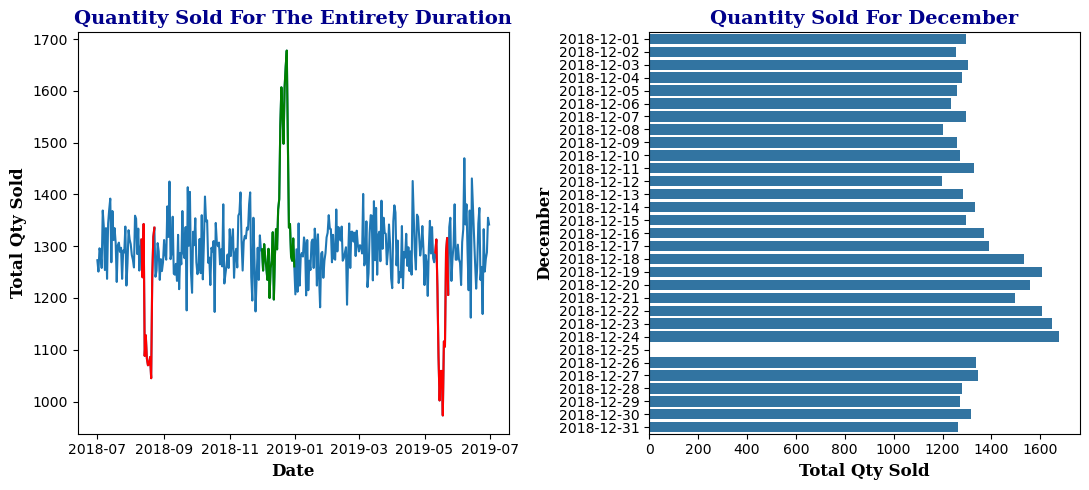

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

# PLOT 1: TOTAL QUANTITY SOLD THROUGH THE YEAR.
qtyByYear = allTrans.groupby(["DATE"], as_index=False).agg({'PROD_QTY': 'sum'})
ax1=plt.subplot(121)
plt.xticks(rotation=0, fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlabel('Date', fontdict=labelFont)
plt.ylabel('Total Qty Sold', fontdict=labelFont)
plt.title('Quantity Sold For The Entirety Duration', fontdict=title_font)

sns.lineplot(x="DATE", y='PROD_QTY', data = qtyByYear, ax = ax1)
sns.lineplot(x="DATE", y='PROD_QTY', data = qtyByYear[
    (qtyByYear["DATE"] > '2018-11-30') & (qtyByYear["DATE"] < '2019-01-01')], color='green', ax = ax1)
sns.lineplot(x="DATE", y='PROD_QTY', data = qtyByYear[
    (qtyByYear["DATE"] > '2018-08-10') & (qtyByYear["DATE"] < '2018-08-24')], color='red', ax = ax1)
sns.lineplot(x="DATE", y='PROD_QTY', data = qtyByYear[
    (qtyByYear["DATE"] > '2019-05-10') & (qtyByYear["DATE"] < '2019-05-24')], color='red', ax = ax1)


# PLOT 2: QUANTITIES SOLD FOR EACH DAY IN DECEMBER
# filter december
december = qtyByYear[qtyByYear['DATE'].isin(
    pd.date_range(start="2018-12-01",end="2018-12-31").tolist())]
# fill in missing dec data
december = december.set_index('DATE').reindex(
    pd.date_range(start="2018-12-01",end="2018-12-31"), fill_value=0)
ax2=plt.subplot(122)
plt.xticks(rotation=0, fontsize=tick_size)
plt.yticks(rotation=0, fontsize=tick_size)
plt.xlabel('Total Qty Sold', fontdict=labelFont)
plt.ylabel('December', fontdict=labelFont)
plt.title('Quantity Sold For December', fontdict=title_font)

sns.barplot(x='PROD_QTY', y=december.index, data = december, ax = ax2)

plt.tight_layout()

<a id='analyse_prodsize'></a>
### 2.3. Analysis By Product Size
Analysing Quantity sold *`By Product Size`*, shows that *`175g`* recorded the highest Quantity sold and *`125g`* recorded the lowest quantity sold.

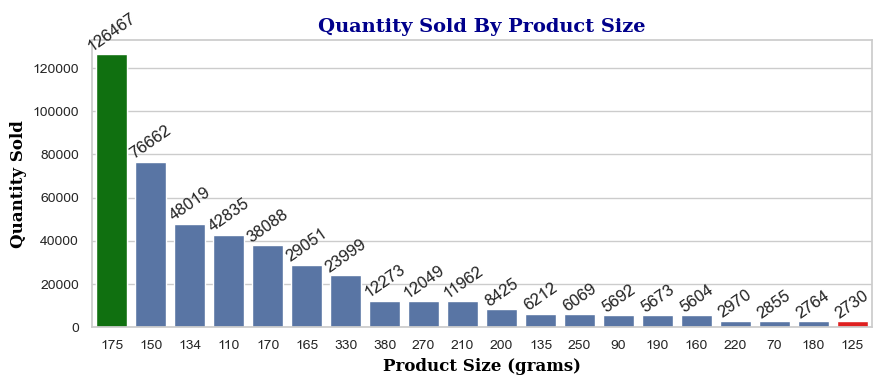

In [44]:
### A GRAPH FOR THE PRODUCT SIZE MOST PURCHASED.
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,4))
sns.set(style='whitegrid')

prodSize = allTrans.groupby(["PROD_SIZE(grams)"], 
                            as_index=False).agg(
                                {"PROD_QTY": "sum"}).sort_values("PROD_QTY", ascending=False)

ax = plt.subplot(111)
plt.xticks(fontsize=tick_size)
plt.yticks(rotation=0, fontsize=tick_size)
plt.xlabel('Product Size (grams)', fontdict=labelFont)
plt.ylabel('Quantity Sold', fontdict=labelFont)
plt.title('Quantity Sold By Product Size', fontdict=title_font)

sns.barplot(x="PROD_SIZE(grams)", y='PROD_QTY', data = prodSize, ax=ax)
sns.barplot(x="PROD_SIZE(grams)", y='PROD_QTY', data = prodSize[
    (prodSize["PROD_SIZE(grams)"]=='175')], color='green', ax=ax)
sns.barplot(x="PROD_SIZE(grams)", y='PROD_QTY', data = prodSize[
    (prodSize["PROD_SIZE(grams)"]=='125')], color='red', ax=ax)
ax.bar_label(ax.containers[0],rotation=35)

plt.tight_layout()

<a id='load_merge_datasets'></a>
## <ins> 3. **Load, Merge And Analyse Both Datasets** </ins>

<a id='load_cust_data'></a>
### 3.1. Load Customer Data
Load the customer data and check the data shape, data format for inconsistencies.

In [20]:
custData = pd.read_csv(
    "C:/Users/DELL/Documents/Data_analytics_projects/Quantium/QVI_purchase_behaviour.csv")
custData.head(3)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget


In [21]:
custData.isnull().value_counts()

LYLTY_CARD_NBR  LIFESTAGE  PREMIUM_CUSTOMER
False           False      False               72637
Name: count, dtype: int64

<a id='merge_datasets'></a>
### 3.2. Merge Transaction and Customer Data
Merging the Transaction Dataframe with Customer Dataframe on the *`LYLTY_CARD_NBR`* column.

In [22]:
left_outer = pd.merge(
    allTrans, custData, how="left", on="LYLTY_CARD_NBR")

left_outer['LIFESTAGE'] = left_outer['LIFESTAGE'].str.lower().str.replace(
    '(singles/couples)', 'people', regex=True)

Concatenating the "PREMIUM_CUSTOMER" and "LIFESTAGE" column into a single column; "Cust_Category", this will make customer grouping much easier.

In [23]:
left_outer['Cust_Category'] = left_outer['PREMIUM_CUSTOMER']+" "+left_outer['LIFESTAGE']
left_outer.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND_NAME,PROD_SIZE(grams),PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,Cust_Category
0,2018-07-01,19,19205,16466,26,Pringles Sweet Spcy BBQ,Pringles,134,1,3.7,older people,Mainstream,Mainstream older people
1,2018-07-01,189,189381,190189,84,GrnWves Plus Btroot Chilli Jam,Grain Waves,180,1,3.1,older families,Mainstream,Mainstream older families
2,2018-07-01,124,124236,127984,104,Infuzions Thai SweetChili PotatoMix,Infuzions,110,1,3.8,older families,Budget,Budget older families


<a id='num_customer_pergroup'></a>
### 3.3. Analysing Number Of Customers Per Category.
Analysing the number of Customers in the *`Premium Categories`* and *`Life stage Categories`*. By Premium Category, *`Mainstream category`* is the most populous, by Lifestage category, *`Retirees`* is the most populous closely followed by *`Older "singles/couples" People`*. A combination of both groups show that *`Mainstream Young "singles/couples" People`* is the most populous.

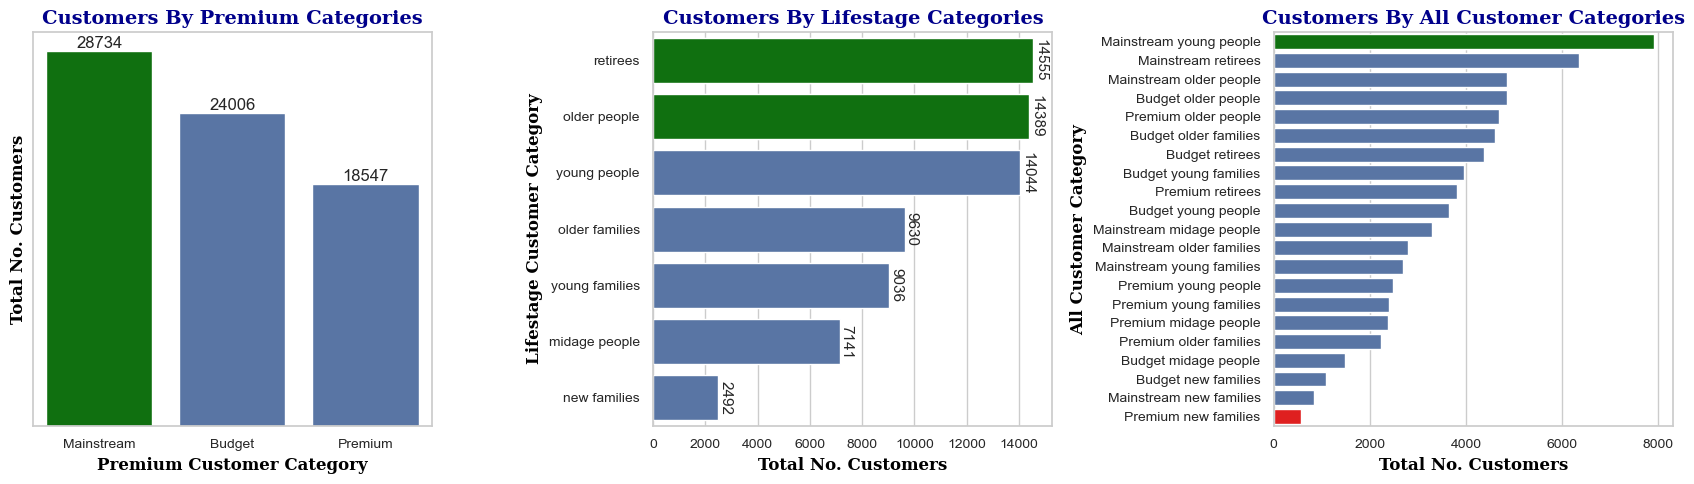

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,5))


#1. Total No. Of Customers In Premium category
premUnique = left_outer.groupby(
    ["PREMIUM_CUSTOMER"], as_index=False).agg(
    {"LYLTY_CARD_NBR": "nunique"}).sort_values("LYLTY_CARD_NBR", ascending=False)
ax1=plt.subplot(131)
plt.yticks([], fontsize=tick_size)
plt.xticks(fontsize=tick_size)
plt.xlabel('Premium Customer Category', fontdict=labelFont)
plt.ylabel('Total No. Customers', fontdict=labelFont)
plt.title('Customers By Premium Categories', fontdict=title_font)

sns.barplot(x="PREMIUM_CUSTOMER", y="LYLTY_CARD_NBR", data = premUnique, ax = ax1)
sns.barplot(x="PREMIUM_CUSTOMER", y="LYLTY_CARD_NBR", data = premUnique[
    (premUnique["PREMIUM_CUSTOMER"]=="Mainstream")], color='green', ax = ax1)
ax1.bar_label(ax1.containers[0], rotation=0, fontsize=12)


#2. Total No. Of Customers In Lifestage category
LifestgUnique = left_outer.groupby(
    ["LIFESTAGE"], as_index=False).agg(
    {"LYLTY_CARD_NBR": "nunique"}).sort_values("LYLTY_CARD_NBR", ascending=False)
ax2=plt.subplot(132)
plt.xticks(rotation=0, fontsize=tick_size)
plt.yticks(rotation=0, fontsize=tick_size)
plt.ylabel('Lifestage Customer Category', fontdict=labelFont)
plt.xlabel('Total No. Customers', fontdict=labelFont)
plt.title('Customers By Lifestage Categories', fontdict=title_font)

sns.barplot(x="LYLTY_CARD_NBR", y="LIFESTAGE", data = LifestgUnique, ax = ax2)
sns.barplot(x="LYLTY_CARD_NBR", y="LIFESTAGE", data = LifestgUnique[
    (LifestgUnique["LIFESTAGE"]=="older people")], color='green', ax = ax2)
sns.barplot(x="LYLTY_CARD_NBR", y="LIFESTAGE", data = LifestgUnique[
    (LifestgUnique["LIFESTAGE"]=="retirees")], color='green', ax = ax2)
ax2.bar_label(ax2.containers[0], rotation=270, fontsize=11)


#3. Total No. Of Customers In Both Lifestage and Premium category.
uniqueInCategory = left_outer.groupby(
    ["Cust_Category"], as_index=False).agg(
    {"LYLTY_CARD_NBR": "nunique"}).sort_values("LYLTY_CARD_NBR", ascending=False)
ax3=plt.subplot(133)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylabel('All Customer Category', fontdict=labelFont)
plt.xlabel('Total No. Customers', fontdict=labelFont)
plt.title('Customers By All Customer Categories', fontdict=title_font)

sns.barplot(data = uniqueInCategory,
            x="LYLTY_CARD_NBR",
            y="Cust_Category", 
            ax = ax3)
sns.barplot(data = uniqueInCategory[(uniqueInCategory["Cust_Category"]=="Mainstream young people")],
            x="LYLTY_CARD_NBR",
            y="Cust_Category", 
            color="green",
            ax = ax3)
sns.barplot(data = uniqueInCategory[(uniqueInCategory["Cust_Category"]=="Premium new families")],
            x="LYLTY_CARD_NBR",
            y="Cust_Category", 
            color="red",
            ax = ax3)


plt.tight_layout()

<a id='transacts_per_group'></a>
### 3.4. No. Of Transactions In Customer Category
This section analyses the number of transactions made by customer category. For premium categories, *`mainstream`* made the most transactions and thats understandable since it is the most populous category. For Lifestage categories, The *`Older "singles/couples" People`* category made the most transactions although it ranks 2nd in customer population. For All Customer categories, *`Budget Older Families`* made the most transactions although it ranks 6th in customer population.

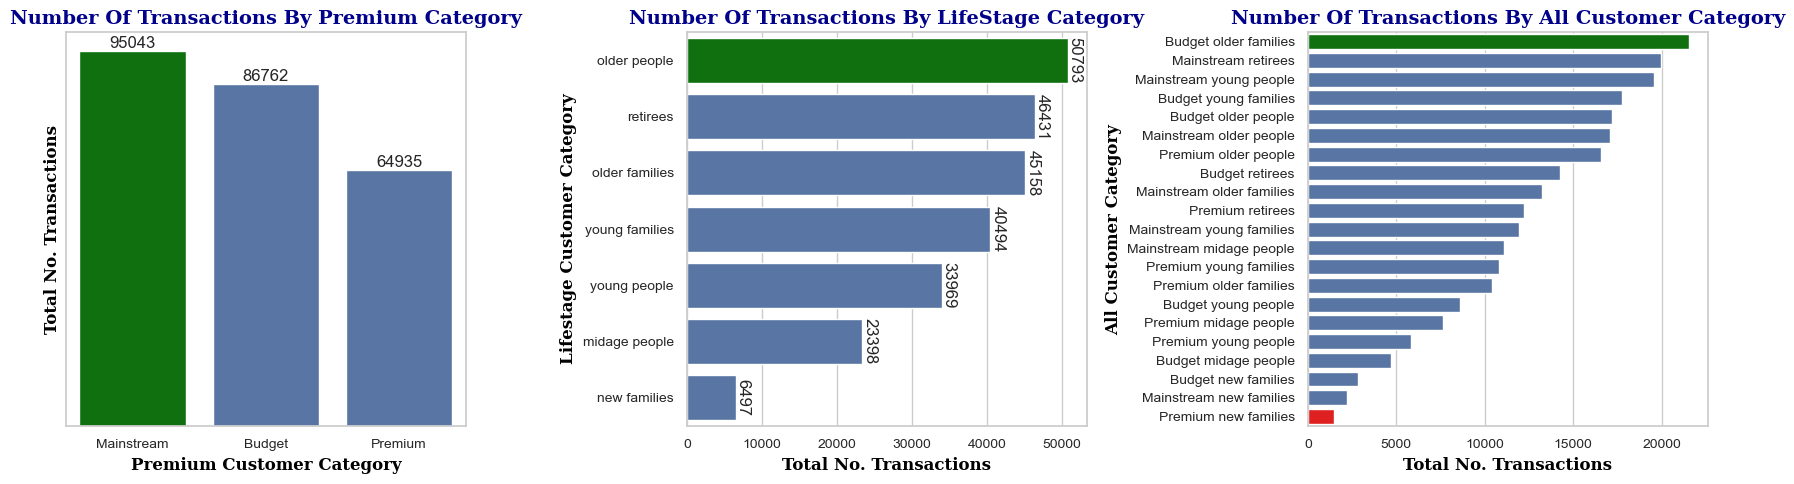

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,5))

#1. Number Of Transactions by Premium category
premCategory = left_outer.groupby(
    ["PREMIUM_CUSTOMER"], as_index=False).agg(
    {"LYLTY_CARD_NBR": "count"}).sort_values("LYLTY_CARD_NBR", ascending=False)
ax1=plt.subplot(131)
plt.yticks([], fontsize=tick_size)
plt.xticks(fontsize=tick_size)
plt.ylabel('Total No. Transactions', fontdict=labelFont)
plt.xlabel('Premium Customer Category', fontdict=labelFont)
plt.title('Number Of Transactions By Premium Category', fontdict=title_font)

sns.barplot(x="PREMIUM_CUSTOMER", y="LYLTY_CARD_NBR", data = premCategory, ax = ax1)
sns.barplot(x="PREMIUM_CUSTOMER", y="LYLTY_CARD_NBR", data = premCategory[
    (premCategory["PREMIUM_CUSTOMER"]=="Mainstream")], color='green', ax = ax1)
ax1.bar_label(ax1.containers[0], rotation=0, fontsize=12)


#2. Number Of Transactions by Lifestage category
LifestgCategory = left_outer.groupby(
    ["LIFESTAGE"], as_index=False).agg(
    {"LYLTY_CARD_NBR": "count"}).sort_values("LYLTY_CARD_NBR", ascending=False)
ax2=plt.subplot(132)
plt.yticks(fontsize=tick_size)
plt.xticks(fontsize=tick_size)
plt.ylabel('Lifestage Customer Category', fontdict=labelFont)
plt.xlabel('Total No. Transactions', fontdict=labelFont)
plt.title('Number Of Transactions By LifeStage Category', fontdict=title_font)

sns.barplot(x="LYLTY_CARD_NBR", y="LIFESTAGE", data = LifestgCategory, ax = ax2)
sns.barplot(x="LYLTY_CARD_NBR", y="LIFESTAGE", data = LifestgCategory[
    (LifestgCategory["LIFESTAGE"]=="older people")], color='green', ax = ax2)
ax2.bar_label(ax2.containers[0], rotation=270, fontsize=12)


#3. Number of Transactions by Both Lifestage and Premium category.
LifePremium = left_outer.groupby(
    ["Cust_Category"], as_index=False).agg(
    {"LYLTY_CARD_NBR": "count"}).sort_values("LYLTY_CARD_NBR", ascending=False)
ax3=plt.subplot(133)
plt.yticks(fontsize=tick_size)
plt.xticks(fontsize=tick_size)
plt.ylabel('All Customer Category', fontdict=labelFont)
plt.xlabel('Total No. Transactions', fontdict=labelFont)
plt.title('Number Of Transactions By All Customer Category', fontdict=title_font)

sns.barplot(x="LYLTY_CARD_NBR", 
                y="Cust_Category",
                data = LifePremium, 
                ax = ax3)
sns.barplot(x="LYLTY_CARD_NBR", 
                y="Cust_Category",
                data = LifePremium[(LifePremium["Cust_Category"]=="Budget older families")], 
                ax = ax3,
                color="green")
sns.barplot(x="LYLTY_CARD_NBR", 
                y="Cust_Category",
                data = LifePremium[(LifePremium["Cust_Category"]=="Premium new families")], 
                ax = ax3,
                color="red")
plt.tight_layout()
# plt.xticks(ticks=[0,50000,100000,150000],rotation=60)

<a id='sales_by_category'></a>
### 3.5. Sales And Quantity Purchased By Customer Category.
This section analyses the customers groups by total sales and quantity sold. *`Budget Older Families`* purchased the most Quantity of chips and this translates into them being the customer group that brought the most revenue, it is also a point to note that this is not the most populous category rather they rank 6th. In terms of Average price per purchase, *`Mainstream Midage "singles/couples" People`* rank highest, this shows their willingness to spend more per purchase. In terms of Averge quantity per purchase, *`older and younegr families`* are generally willing to buy more, it can be assumed that they buy more because they will have children who also eat chips.

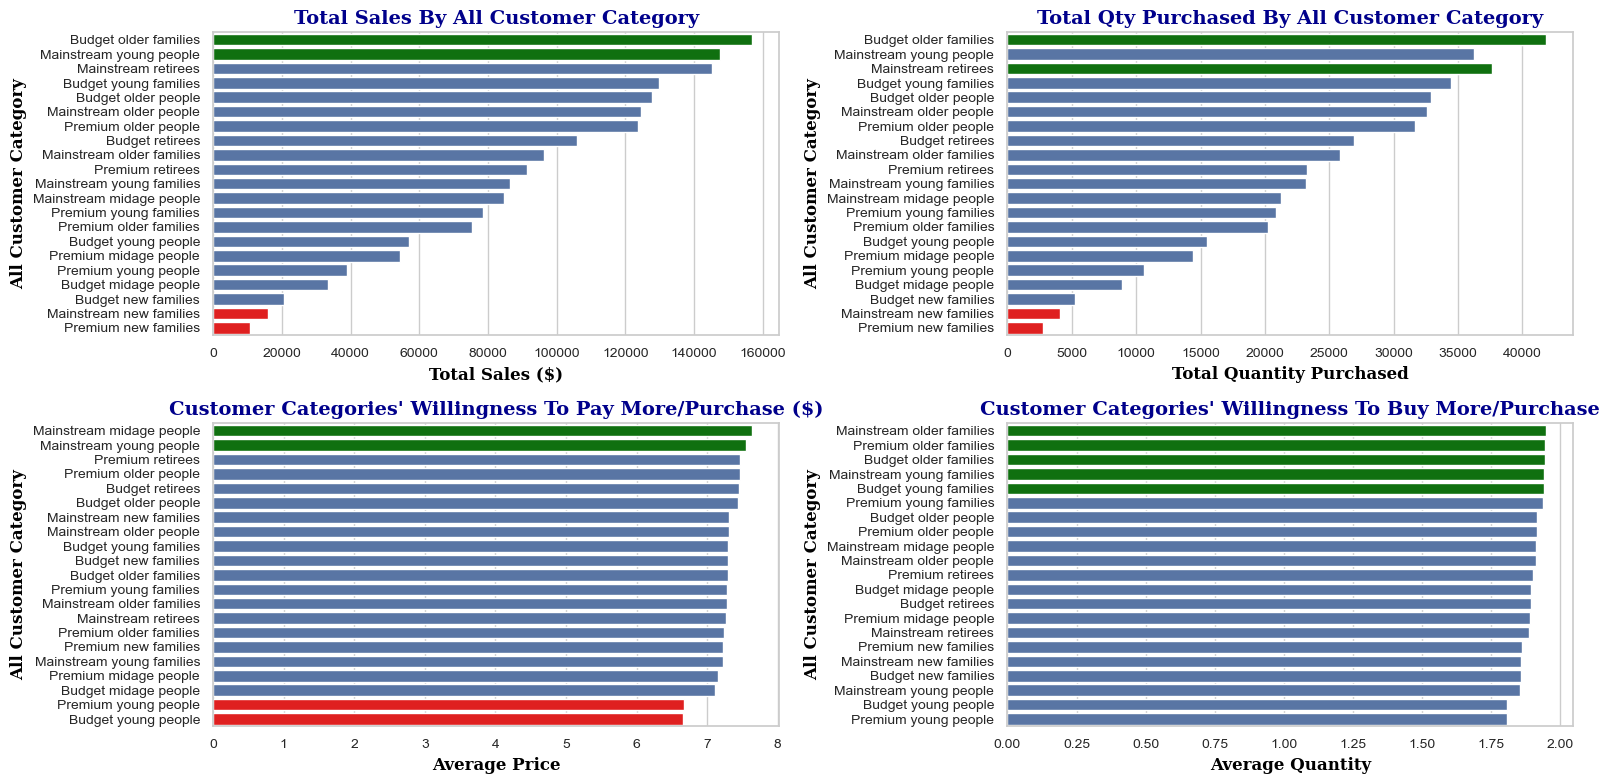

In [26]:
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

sumSalesByGroup = left_outer.groupby(
    ["Cust_Category"], as_index=False).agg(
    {"TOT_SALES":"sum", "PROD_QTY":"sum"}).sort_values(["TOT_SALES"], ascending=False)

meanSalesByGroup = left_outer.groupby(
    ["Cust_Category"], as_index=False).agg(
    {"TOT_SALES":"mean"}).sort_values(["TOT_SALES"], ascending=False)

meanQtyByGroup = left_outer.groupby(
    ["Cust_Category"], as_index=False).agg(
    {"PROD_QTY":"mean"}).sort_values(["PROD_QTY"], ascending=False)


#1. ANALYSING CUSTOMER SEGMENT THAT CONTRIBUTE MOST TO SALES
ax1=plt.subplot(221)
plt.yticks(fontsize=tick_size)
plt.xticks(fontsize=tick_size)
plt.ylabel('All Customer Category', fontdict=labelFont)
plt.xlabel('Total Sales ($)', fontdict=labelFont)
plt.title('Total Sales By All Customer Category', fontdict=title_font)

sns.barplot(x="TOT_SALES", y="Cust_Category", data = sumSalesByGroup, ax = ax1)
sns.barplot(x="TOT_SALES", y="Cust_Category", data = sumSalesByGroup[
    (sumSalesByGroup["Cust_Category"]=="Budget older families")], color='green', ax = ax1)
sns.barplot(x="TOT_SALES", y="Cust_Category", data = sumSalesByGroup[
    (sumSalesByGroup["Cust_Category"]=="Mainstream young people")], color='green', ax = ax1)
sns.barplot(x="TOT_SALES", y="Cust_Category", data = sumSalesByGroup[
    (sumSalesByGroup["Cust_Category"]=="Premium new families")], color='red', ax = ax1)
sns.barplot(x="TOT_SALES", y="Cust_Category", data = sumSalesByGroup[
    (sumSalesByGroup["Cust_Category"]=="Mainstream new families")], color='red', ax = ax1)

# ax1.plot(156864, "Budget older families", "*", markersize=10, color="r")
# ax1.bar_label(ax1.containers[0], rotation=0, fontsize=11)


#2. ANALYSING CUSTOMER SEGMENT THAT BOUGHT MOST PRODUCT
ax2=plt.subplot(222)
plt.yticks(fontsize=tick_size)
plt.xticks(fontsize=tick_size)
plt.ylabel('All Customer Category', fontdict=labelFont)
plt.xlabel('Total Quantity Purchased', fontdict=labelFont)
plt.title('Total Qty Purchased By All Customer Category', fontdict=title_font)

sns.barplot(x="PROD_QTY", y="Cust_Category", data = sumSalesByGroup, ax = ax2)
sns.barplot(x="PROD_QTY", y="Cust_Category", data = sumSalesByGroup[
    (sumSalesByGroup["Cust_Category"]=="Budget older families")], color='green', ax = ax2)
sns.barplot(x="PROD_QTY", y="Cust_Category", data = sumSalesByGroup[
    (sumSalesByGroup["Cust_Category"]=="Mainstream retirees")], color='green', ax = ax2)
sns.barplot(x="PROD_QTY", y="Cust_Category", data = sumSalesByGroup[
    (sumSalesByGroup["Cust_Category"]=="Premium new families")], color='red', ax = ax2)
sns.barplot(x="PROD_QTY", y="Cust_Category", data = sumSalesByGroup[
    (sumSalesByGroup["Cust_Category"]=="Mainstream new families")], color='red', ax = ax2)
# ax1.bar_label(ax1.containers[0], rotation=0, fontsize=11)


#3. ANALYSING CUSTOMER SEGMENT MOST WILLING TO SPEND MORE PER PURCHASE.
ax3=plt.subplot(223)
plt.yticks(fontsize=tick_size)
plt.xticks(fontsize=tick_size)
plt.ylabel('All Customer Category', fontdict=labelFont)
plt.xlabel('Average Price', fontdict=labelFont)
plt.title("Customer Categories' Willingness To Pay More/Purchase ($)", fontdict=title_font)

sns.barplot(x="TOT_SALES", y="Cust_Category", data = meanSalesByGroup, ax = ax3)
sns.barplot(x="TOT_SALES", y="Cust_Category", data = meanSalesByGroup[
    (meanSalesByGroup["Cust_Category"]=="Mainstream midage people")], color='green', ax = ax3)
sns.barplot(x="TOT_SALES", y="Cust_Category", data = meanSalesByGroup[
    (meanSalesByGroup["Cust_Category"]=="Mainstream young people")], color='green', ax = ax3)
sns.barplot(x="TOT_SALES", y="Cust_Category", data = meanSalesByGroup[
    (meanSalesByGroup["Cust_Category"]=="Budget young people")], color='red', ax = ax3)
sns.barplot(x="TOT_SALES", y="Cust_Category", data = meanSalesByGroup[
    (meanSalesByGroup["Cust_Category"]=="Premium young people")], color='red', ax = ax3)
# ax1.plot(156864, "Budget older families", "*", markersize=10, color="r")


#4. ANALYSING CUSTOMER SEGMENT MOST WILLING TO BUY MORE CHIPS PER PURCHASE.
ax4=plt.subplot(224)
plt.yticks(fontsize=tick_size)
plt.xticks(fontsize=tick_size)
plt.ylabel('All Customer Category', fontdict=labelFont)
plt.xlabel('Average Quantity', fontdict=labelFont)
plt.title("Customer Categories' Willingness To Buy More/Purchase", fontdict=title_font)

sns.barplot(x="PROD_QTY", y="Cust_Category", data = meanQtyByGroup, ax = ax4)
sns.barplot(x="PROD_QTY", y="Cust_Category", data = meanQtyByGroup[
    (meanQtyByGroup["Cust_Category"]=="Budget young families")], color='green', ax = ax4)
sns.barplot(x="PROD_QTY", y="Cust_Category", data = meanQtyByGroup[
    (meanQtyByGroup["Cust_Category"]=="Budget older families")], color='green', ax = ax4)
sns.barplot(x="PROD_QTY", y="Cust_Category", data = meanQtyByGroup[
    (meanQtyByGroup["Cust_Category"]=="Mainstream older families")], color='green', ax = ax4)
sns.barplot(x="PROD_QTY", y="Cust_Category", data = meanQtyByGroup[
    (meanQtyByGroup["Cust_Category"]=="Premium older families")], color='green', ax = ax4)
sns.barplot(x="PROD_QTY", y="Cust_Category", data = meanQtyByGroup[
    (meanQtyByGroup["Cust_Category"]=="Mainstream young families")], color='green', ax = ax4)

plt.tight_layout()

<a id='statistical_analysis'></a>
## <ins> **4.0. Independent Ttest, Basket Analysis And Affinity Test.** </ins>

<a id='ttest_overview'></a>
### 4.1. Overview Of Independent T-test.

#### **<ins>The Independent T-test</ins>**
This is a statistical analysis used to compare the mean values of two unrelated sample groups, the aim of the test is to determine if the mean of the samples are statistically different from each other.<br>
<ins>**Basic Hypotheses**</ins><br>
1. **Null**: The sample mean from Group 1 is not different from the sample mean from Group 2.<br>
2. **Alternative**: The sample mean from Group 1 is significantly different from the sample mean from Group 2.<br>

<ins>**The Output**</ins> of a T-test is in the format `(t(degrees of freedom) = the t statistic, p = p value)`. <ins>**Interpretation:**</ins> 1st, When the p-value is `less than` the level of `significance: p < .05`; in this case, `there is enough evidence to prove that the mean values of both groups are statistically different, significant and acceptable`. 2nd, When the p-value is `greater than` the level of `significance: p > .05`; in this case, `there is not enough evidence to prove that the mean values of both groups are statistically different and significant, hence, it will be rejected` (In this case, you want to report the p-value as exactly: p = .24).  <ins>*SOURCE:*</ins> [*Statistic Resources*](https://resources.nu.edu/statsresources/IndependentSamples#:~:text=The%20independent%20samples%20t%2Dtest,are%20different%20from%20each%20other).<br>
Also, it isn't uncommon to compare 2 or more p-values from multiple t-test groups in a dataset, in cases like this, e.g a t-test with a p-value of 0.06 and the other t-test with p-value of 0.04; the group and the result with the lesser p-value or p-value less than 0.05 will be considered more statistically significant.

<a id='ttest_analysis'></a>
### 4.2. Independent T-test Analysis.

This section carries out an Independent T-test to statistically determine if the mean price per unit of the following groups are statistically significant or acceptable:<br>
1. Mainstream: Midage People VS Young People `(statistic=2.9525917349242317, pvalue=0.003153574503571613)`,
2. Premium: Midage People VS Young People `(statistic=10.688544156030247, pvalue=1.471703823737355e-26)`,
3. Budget: Midage People VS Young People `(statistic=9.459045052841606, pvalue=3.623561628106184e-21)`.

All the 3 groups have `p-values less than .05`; meaning that there is enough evidence to prove that the mean prices/ unit prices (purchasing power) of the 6 Customer groups are statistically different, significant and acceptable. The t-test result of the Mainstream: Young and Midage mean price have a p-value of 0.00315, which is significantly higher than that of Budget or Premium; Young and Midage People.

In [27]:
ttestMeanSales = left_outer.groupby("Cust_Category", as_index=False) 
# ttest_ind(group1["column"],group2["column"])
print("Mainstream: Midage V Young::",
      ttest_ind((ttestMeanSales.get_group("Mainstream midage people")["TOT_SALES"]), 
                (ttestMeanSales.get_group("Mainstream young people")["TOT_SALES"])))

Mainstream: Midage V Young:: TtestResult(statistic=2.9525917349242317, pvalue=0.003153574503571613, df=30637.0)


In [28]:
print("Premium: Midage V Young::",
      ttest_ind((ttestMeanSales.get_group("Premium midage people")["TOT_SALES"]), 
                (ttestMeanSales.get_group("Premium young people")["TOT_SALES"])))

Premium: Midage V Young:: TtestResult(statistic=10.688544156030247, pvalue=1.471703823737355e-26, df=13462.0)


In [29]:
print("Budget: Midage V Young::",
      ttest_ind((ttestMeanSales.get_group("Budget midage people")["TOT_SALES"]), 
                (ttestMeanSales.get_group("Budget young people")["TOT_SALES"])))

Budget: Midage V Young:: TtestResult(statistic=9.459045052841606, pvalue=3.623561628106184e-21, df=13262.0)


<a id='mba_overview'></a>
### 4.3. Overview Of Market Basket and Affinity Analysis.

#### <ins>**Market basket analysis (MBA)**</ins> 
This is a strategic data mining technique used to enhance sales by gaining a deeper understanding of customer purchasing patterns. This method entails the examination of an historical purchase records in order to unveil inherent product groupings and identify items that tend to be bought together. By recognizing these patterns of co-occurrence, retailers can make informed decisions to optimize inventory management, devise effective marketing strategies, employ cross-selling tactics, and even refine store layout for improved customer engagement. There are 4 types of Algorithms commonly used; `Apriori Algorithm, AIS Algorithm, SETM Algorithm and Frequent Pattern Growth (FP Growth)`.

#### <ins>**Apriori Algorithm (Algorithm Used)**</ins>
Apriori Algorithm is a widely-used and well-known Association Rule algorithm and is a popular algorithm used in market basket analysis. It is also considered accurate and overtop AIS and SETM algorithms. It helps to find frequent itemsets in transactions and identifies association rules between these items. The limitation of the Apriori Algorithm is frequent itemset generation. It needs to scan the database many times, leading to increased time and reduced performance as a computationally costly step because of a large dataset. It uses the concepts of Confidence and Support.

#### <ins>**Terminologies**</ins>
1. <ins>**ITEMSET:**</ins> This is the collection/list of unique products that customers purchase during the analysis timeframe.
2. <ins>**ANTECEDENT:**</ins> In assocoation rule minnig, the first feature is called the antecedent.
3. <ins>**CONSEQUENT:**</ins> In association rule minnig, the co-occuring feature with considerable relationship with the antecedent.
4. <ins>**SUPPORT:**</ins> In Association rule mining, we use it to assess the overall popularity of a given product with the following `formula: Support(item) = Transactions comprising the item / Total transactions`
5. <ins>**CONFIDENCE:**</ins> In association rule minnig, Confidence tells us the likelihood of different purchase combinations. We calculate that using the following `formula: Confidence (Bread -> Milk) = Transactions comprising bread and milk / Transactions comprising bread`. In this case, it can show how many users who purchased bread also bought milk.
6. <ins>**LIFT:**</ins> Lift refers to the increase in the ratio of the sale of consequent (milk) when you sell the antecedent (bread): `Lift = Confidence (Antecedent e.g Bread -> Consequent e.g Milk) / Support(Antecedent Bread)`. If the `lift > 1` e.g = 0.75/1 = 1.3. This means that customers are 1.3 times more likely to buy milk if you also sell bread (antecedent increases the chances of buying the consequent). If `Lift < 1` e.g = 0.6 indicates that purchasing the antecedent reduces the chances of purchasing the consequent in the same transaction. Note: This could indicate that the items are seen by customers as alternatives to each other. When the `lift = 1`, then purchasing the antecedent makes no difference on the chances of purchasing the consequent. <ins>*SOURCE:*</ins> [365DataScience](https://365datascience.com/tutorials/python-tutorials/market-basket-analysis/)

<a id='mainyoung_brand_affinity'></a>
### 4.4. MBA By Brand For "Mainstream young people
The MBA analysis shows that *`Mainstream Young "singles/couples" People`* are most probably going to buy the *`Kettle`* brand. The analysis also shows association between some product brands, the most most notable being the *`Pringles (antecedent) and Kettle (consequent)`* pair which has the highest *`support (.091449) and Lift (.922148)`* of all the associated pairs but with a lift value of *`0.922148`* which is *`~1`* it can be *`implied that the purchase of Pringles has a very negligible effect on the chances of purchasing Kettle.`*

In [30]:
basket_filter = left_outer[(left_outer['Cust_Category']=="Mainstream young people")]
basket_filter.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND_NAME,PROD_SIZE(grams),PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,Cust_Category
53,2018-07-01,176,176365,177355,90,Tostitos Smoked Chipotle,Tostitos,175,2,8.8,young people,Mainstream,Mainstream young people
55,2018-07-01,178,178035,177772,114,Kettle Sensations Siracha Lime,Kettle,150,2,9.2,young people,Mainstream,Mainstream young people
60,2018-07-01,260,260197,259407,25,Pringles SourCream Onion,Pringles,134,2,7.4,young people,Mainstream,Mainstream young people
72,2018-07-01,215,215078,214262,15,Twisties Cheese,Twisties,270,2,9.2,young people,Mainstream,Mainstream young people
73,2018-07-01,43,43195,39945,67,RRD Chilli Coconut,RRD,150,2,5.4,young people,Mainstream,Mainstream young people


In [31]:
brand_basket = pd.crosstab(basket_filter["LYLTY_CARD_NBR"],
                   basket_filter["BRAND_NAME"])
brand_basket.head()

BRAND_NAME,Burger,CCs,Cheetos,Cheezels,Cobs,Doritos,French,Grain,Grain Waves,Infuzions,...,Natural,Pringles,RRD,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,WW
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,,
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1010,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1018,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1020,0,0,0,0,0,0,0,0,1,0,...,0,0,0,2,0,0,0,0,0,0
1060,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [32]:
def encode(item_freq):
    response = False
    if item_freq > 0:
        response = True
    return response

brand_basket_input = brand_basket.map(encode)
brand_basket_input.head()

BRAND_NAME,Burger,CCs,Cheetos,Cheezels,Cobs,Doritos,French,Grain,Grain Waves,Infuzions,...,Natural,Pringles,RRD,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,WW
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,,
1002,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1010,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1018,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
1020,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
1060,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [33]:
brand_freq_itemsets = apriori(brand_basket_input, min_support=0.07, 
                            use_colnames=True).sort_values("support", 
                                                           ascending=False)
brand_freq_itemsets.sort_values("support", ascending=False)

,support,itemsets
4,0.387142,(Kettle)
1,0.260326,(Doritos)
5,0.256158,(Pringles)
7,0.202476,(Smiths)
8,0.136036,(Thins)
3,0.112164,(Infuzions)
10,0.107364,(Twisties)
9,0.105848,(Tostitos)
0,0.103827,(Cobs)
6,0.093975,(RRD)


In [34]:
brand_rules = association_rules(brand_freq_itemsets, 
                          metric="lift").sort_values("support", 
                                                     ascending=False)
brand_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Pringles),(Kettle),0.256158,0.387142,0.091449,0.357002,0.922148,-0.007720,0.953126,-0.101929
1,(Kettle),(Pringles),0.387142,0.256158,0.091449,0.236215,0.922148,-0.007720,0.973890,-0.121076
2,(Kettle),(Doritos),0.387142,0.260326,0.089933,0.232300,0.892344,-0.010850,0.963494,-0.164477
3,(Doritos),(Kettle),0.260326,0.387142,0.089933,0.345463,0.892344,-0.010850,0.936324,-0.140232
4,(Smiths),(Kettle),0.202476,0.387142,0.075660,0.373674,0.965214,-0.002727,0.978498,-0.043236


<a id='mainyoung_size_affinity'></a>
### 4.5. MBA By "Prod_SIze" For "Mainstream young people"
The MBA analysis shows that *`Mainstream Young "singles/couples" People`* are most probably going to buy a *`product of size 175grams`* brand. The analysis also shows association between some product sizes the most notable pair being; the *`150gram (antecedent) and 175gram (consequent)`* pair has the highest *`support (.137931) and Lift (.959322)`* of all the associated pairs but with a lift value of *`.959322`* which is *`~1`* it can be *`implied that the purchase of 150gram product has a very negligible effect on the chances of purchasing a 175 gram product.`*

In [35]:
size_basket = pd.crosstab(basket_filter["LYLTY_CARD_NBR"],
                   basket_filter["PROD_SIZE(grams)"])
size_basket.head()

PROD_SIZE(grams),110,125,134,135,150,160,165,170,175,180,190,200,210,220,250,270,330,380,70,90
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,
1002,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1010,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1018,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1020,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1060,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0


In [36]:
def encode(item_freq):
    response = False
    if item_freq > 0:
        response = True
    return response

size_basket_input = size_basket.map(encode)
size_basket_input.head()

PROD_SIZE(grams),110,125,134,135,150,160,165,170,175,180,190,200,210,220,250,270,330,380,70,90
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,
1002,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1010,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1018,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
1020,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
1060,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False


In [37]:
size_freq_itemsets = apriori(size_basket_input, min_support=0.07, 
                            use_colnames=True).sort_values("support", 
                                                           ascending=False)
size_freq_itemsets.sort_values("support", ascending=False)

,support,itemsets
5,0.458254,(175)
2,0.313755,(150)
1,0.256158,(134)
0,0.224454,(110)
4,0.176835,(170)
8,0.139320,(330)
13,0.137931,"(175, 150)"
3,0.127700,(165)
12,0.111153,"(175, 134)"
10,0.094480,"(175, 110)"


In [38]:
size_rules = association_rules(size_freq_itemsets, 
                          metric="lift").sort_values("support", 
                                                     ascending=False)
size_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(175),(150),0.458254,0.313755,0.137931,0.300992,0.959322,-0.005849,0.981741,-0.072589
1,(150),(175),0.313755,0.458254,0.137931,0.439614,0.959322,-0.005849,0.966736,-0.058194
2,(175),(134),0.458254,0.256158,0.111153,0.242558,0.946909,-0.006232,0.982045,-0.093789
3,(134),(175),0.256158,0.458254,0.111153,0.433925,0.946909,-0.006232,0.957021,-0.070093
4,(175),(110),0.458254,0.224454,0.094480,0.206174,0.918560,-0.008377,0.976973,-0.140640


<a id='rem_cust_size_affinity'></a>
### 4.6. MBA By "Prod_SIze" For Remaining Customers.
The MBA analysis was carried out for the remaining customers to know their preferred product size. The analysis shows that *`175 grams with support of .585577`* is the most preferred product size. Regarding the association analysis it is shown that the most notable pair is; the *`150gram (antecedent) and 175gram (consequent)`* pair has the highest *`support (.263958) and Lift (1.062884)`* of all the associated pairs but with a lift value of *`1.062884`* which is still aproximately *`~1`* it can be *`implied that the purchase of 150gram product has a very negligible effect on the chances of purchasing a 175 gram product.`* In conclusion, it can be implied that *`Mainstream young people and the rest of the population have the same preference when it comes to product sizes as 175 grams and 150 grams are their most preferred choices`*.

In [39]:
rem_cust = left_outer[(left_outer["Cust_Category"]!="Mainstream young people")]
rem_cust.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND_NAME,PROD_SIZE(grams),PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,Cust_Category
0,2018-07-01,19,19205,16466,26,Pringles Sweet Spcy BBQ,Pringles,134,1,3.7,older people,Mainstream,Mainstream older people
1,2018-07-01,189,189381,190189,84,GrnWves Plus Btroot Chilli Jam,Grain Waves,180,1,3.1,older families,Mainstream,Mainstream older families
2,2018-07-01,124,124236,127984,104,Infuzions Thai SweetChili PotatoMix,Infuzions,110,1,3.8,older families,Budget,Budget older families
3,2018-07-01,70,70131,68241,60,Kettle Tortilla ChpsFeta Garlic,Kettle,150,2,9.2,retirees,Premium,Premium retirees
4,2018-07-01,33,33140,30342,10,RRD SR Slow Rst Pork Belly,RRD,150,2,5.4,young families,Mainstream,Mainstream young families


In [40]:
size_basket_all = pd.crosstab(rem_cust["LYLTY_CARD_NBR"],
                   rem_cust["PROD_SIZE(grams)"])
size_basket_all.head()

PROD_SIZE(grams),110,125,134,135,150,160,165,170,175,180,190,200,210,220,250,270,330,380,70,90
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1003,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1004,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1005,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1007,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
def encode(item_freq):
    response = False
    if item_freq > 0:
        response = True
    return response

all_size_input = size_basket_all.map(encode)
all_size_input.head()

PROD_SIZE(grams),110,125,134,135,150,160,165,170,175,180,190,200,210,220,250,270,330,380,70,90
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,
1000,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1003,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
1004,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1005,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1007,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [42]:
all_size_freq_itemsets = apriori(all_size_input, min_support=0.09, 
                            use_colnames=True).sort_values("support", 
                                                           ascending=False)
all_size_freq_itemsets.sort_values("support", ascending=False)

,support,itemsets
5,0.585577,(175)
2,0.424097,(150)
1,0.293972,(134)
0,0.266703,(110)
13,0.263958,"(175, 150)"
4,0.244848,(170)
3,0.192804,(165)
10,0.179312,"(175, 134)"
8,0.163484,"(175, 110)"
6,0.160628,(330)


In [43]:
all_size_rules = association_rules(all_size_freq_itemsets, 
                          metric="lift").sort_values("support", 
                                                     ascending=False)
all_size_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(175),(150),0.585577,0.424097,0.263958,0.450765,1.062884,0.015617,1.048556,0.142761
1,(150),(175),0.424097,0.585577,0.263958,0.622400,1.062884,0.015617,1.097519,0.102731
2,(175),(134),0.585577,0.293972,0.179312,0.306214,1.041645,0.007169,1.017646,0.096471
3,(134),(175),0.293972,0.585577,0.179312,0.609963,1.041645,0.007169,1.062523,0.056626
4,(175),(110),0.585577,0.266703,0.163484,0.279185,1.046800,0.007309,1.017316,0.107878
